# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers deep learning techniques, namely:
- Variational Graph Normalized Auto-Encoders (based on https://arxiv.org/abs/2108.08046) which allow us to learn graph embeddings in an unsupervised way (based on graph structure and node embeddings)

### 1. Import Packages

In [43]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\autoencoder.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [48]:
# parse & handle data
import os
import numpy as np
import pandas as pd

# modeling
import torch
from torch_geometric.nn import GAE, VGAE

# hyperparam optimization
from ray import tune, air

# evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [4]:
# might take up to a minute
data, (G, G_train, node_info, train_tf, val_tf, trainval_tf, test, test_tf) = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


In [5]:
# where to save trial results to
ray_path = os.path.abspath("")+"\\ray_results\\"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

### 3. VGNAE Node Embeddings

https://github.com/SeongJinAhn/VGNAE/blob/main/main.py for Variational Graph Normalized Auto-Encoders

#### 3.1 Hyperparameter tuning

In [6]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # log params in raytune
    "ray": True,
    
    # print results per epoch
    "verbose": False,
    
    # basic infos
    "data": data,
    "max_epochs": 50,
    "save": True, # if we want to save best model on validation set
    
    # model
    "model": "VGAE",
    "enc_channels": 2,
    
    # optimizer
    "lr": tune.grid_search([1e-5, 5e-5, 1e-4]),
    "wd": tune.grid_search([1e-2, 1e-4])
}

In [7]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = autoenc.run_ray_experiment(
    autoenc.train_validate, config, ray_path, num_samples,
    metric_columns = ["trn_auc", "val_auc", "max_val_auc", "training_iteration"],
    parameter_columns = ["model", "lr", "wd"]
)

2023-03-10 21:00:42,327	INFO worker.py:1553 -- Started a local Ray instance.
2023-03-10 21:01:10,643	INFO tune.py:798 -- Total run time: 27.02 seconds (22.22 seconds for the tuning loop).


#### 3.2 Embeddings based on best model

In [53]:
# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], config["enc_channels"]))
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [54]:
# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data)

Text(0.5, 1.0, 'VGNAE projection (first 2 dim) of nodes')

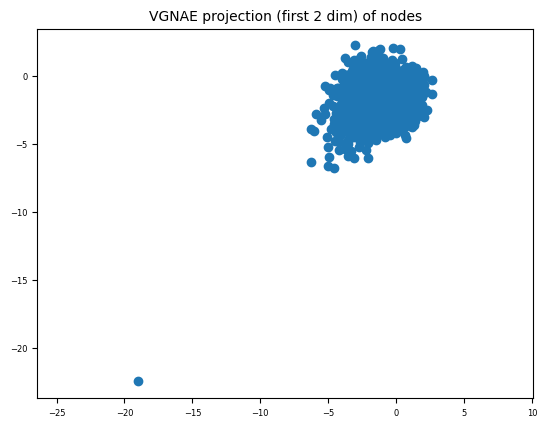

In [55]:
# plot embedding
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('VGNAE projection (first 2 dim) of nodes')

In [56]:
node_emb = pd.DataFrame(embedding).rename(columns = {0: "x1", 1: "x2"})

In [57]:
tmp = (val_tf
    .assign(sim  = y_val_hat.pred.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

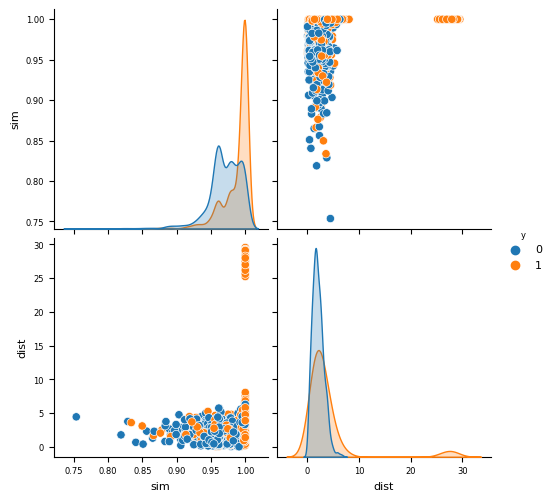

In [58]:
sns.pairplot(tmp[["sim", "dist", "y"]], hue = "y")

In [59]:
tmp.corr()

,node1,node2,y,sim,dist
node1,1.000000,0.493127,0.036595,0.196453,-0.035406
node2,0.493127,1.000000,0.059586,0.243821,-0.029610
y,0.036595,0.059586,1.000000,0.369766,0.209273
sim,0.196453,0.243821,0.369766,1.000000,0.189464
dist,-0.035406,-0.029610,0.209273,0.189464,1.000000


#### 3.3 Compute edge features based on best model

In [60]:
# predict train
y_train_hat = pd.DataFrame(autoenc.get_similarity(model, data, data.train_edges))
y_train_hat = (y_train_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.train_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
print("ROC: ", roc_auc_score(y_train_hat.y, y_train_hat.sim))
print("Acc: ", accuracy_score(y_train_hat.y, y_train_hat.pred))

ROC:  0.811143839914642
Acc:  0.7085523172479694


In [61]:
# predict val
y_val_hat = pd.DataFrame(autoenc.get_similarity(model, data, data.val_edges))
y_val_hat = (y_val_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.val_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
print("ROC: ", roc_auc_score(y_val_hat.y, y_val_hat.sim))
print("Acc: ", accuracy_score(y_val_hat.y, y_val_hat.pred))

ROC:  0.7767164315390587
Acc:  0.7138079311992356


In [63]:
# predict test
y_test_hat = pd.DataFrame(autoenc.get_similarity(model, data, data.test_edges))
y_test_hat = (y_test_hat
    .rename(columns = {0: "sim"})
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
y_test_hat[["pred"]].value_counts()

pred
0       1741
1       1740
dtype: int64

### X. Code Graveyard

previous code without functions

In [16]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 2
model = VGAE(deep.Encoder(data.x.size()[1], channels)).to(dev)

In [17]:
x, train_pos_edges, train_neg_edges = data.x.to(dev), data.train_pos_edges.to(dev), data.train_neg_edges.to(dev)
val_pos_edges, val_neg_edges = data.val_pos_edges.to(dev), data.val_neg_edges.to(dev)
val_edges = data.val_edges.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay = 0.1)

In [20]:
def train():
    model.train()
    optimizer.zero_grad()
    z  = model.encode(x, train_pos_edges)
    loss = model.recon_loss(z, train_pos_edges, train_neg_edges)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    auc, ap = validate(data.train_pos_edges, data.train_neg_edges)
    return loss, auc, ap

def validate(val_pos_edges, val_neg_edges):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edges)
    return model.test(z, val_pos_edges, val_neg_edges)

def predict(edges):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edges)
    pred = model.decoder(z, edges, sigmoid = True)
    return pred.detach().cpu().numpy()

def get_embeddings():
    return model.encode(x, train_pos_edges).detach().cpu().numpy()

In [21]:
for epoch in range(1,50):
    loss, trn_auc, trn_ap = train()
    loss = float(loss)
    
    with torch.no_grad():
        auc, ap = validate(data.val_pos_edges, data.val_neg_edges)
        print('Epoch: {:03d}, LOSS: {:.4f}, Trn AUC: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, trn_auc, auc, ap))

Epoch: 001, LOSS: 3.9292, Trn AUC: 0.7867, Val AUC: 0.7420, Val AP: 0.7823
Epoch: 002, LOSS: 4.0428, Trn AUC: 0.7866, Val AUC: 0.7420, Val AP: 0.7822
Epoch: 003, LOSS: 3.9016, Trn AUC: 0.7866, Val AUC: 0.7419, Val AP: 0.7822
Epoch: 004, LOSS: 4.0921, Trn AUC: 0.7865, Val AUC: 0.7419, Val AP: 0.7821
Epoch: 005, LOSS: 4.0718, Trn AUC: 0.7865, Val AUC: 0.7418, Val AP: 0.7820
Epoch: 006, LOSS: 3.9491, Trn AUC: 0.7864, Val AUC: 0.7417, Val AP: 0.7819
Epoch: 007, LOSS: 3.9936, Trn AUC: 0.7864, Val AUC: 0.7417, Val AP: 0.7819
Epoch: 008, LOSS: 3.9383, Trn AUC: 0.7863, Val AUC: 0.7416, Val AP: 0.7818
Epoch: 009, LOSS: 4.0555, Trn AUC: 0.7863, Val AUC: 0.7415, Val AP: 0.7817
Epoch: 010, LOSS: 4.1547, Trn AUC: 0.7862, Val AUC: 0.7414, Val AP: 0.7817
Epoch: 011, LOSS: 3.9986, Trn AUC: 0.7862, Val AUC: 0.7413, Val AP: 0.7816
Epoch: 012, LOSS: 3.9577, Trn AUC: 0.7861, Val AUC: 0.7412, Val AP: 0.7815
Epoch: 013, LOSS: 3.9537, Trn AUC: 0.7860, Val AUC: 0.7412, Val AP: 0.7815
Epoch: 014, LOSS: 3.9163,

In [14]:
# predict train
train_edges = data.train_edges.to(dev)
y_train_hat = pd.DataFrame(predict(train_edges))
y_train_hat = (y_train_hat
    .rename(columns = {0: "pred"})
    .assign(y = trainval_tf.loc[trainval_tf.train_mask == True].y.values)
    .assign(bin_pred = lambda df_: (df_.pred > df_.pred.median()).astype(int))
)

NameError: name 'trainval_tf' is not defined

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score
print("ROC: ", roc_auc_score(y_train_hat.y, y_train_hat.pred))
print("Acc: ", accuracy_score(y_train_hat.y, y_train_hat.bin_pred))

In [625]:
# predict val
val_edges = data.val_edges.to(dev)
y_val_hat = pd.DataFrame(predict(val_edges))
y_val_hat = (y_val_hat
    .rename(columns = {0: "pred"})
    .assign(y = trainval_tf.loc[trainval_tf.val_mask == True].y.values)
    .assign(bin_pred = lambda df_: (df_.pred > df_.pred.median()).astype(int))
)

In [626]:
from sklearn.metrics import average_precision_score, roc_auc_score
print("ROC: ", roc_auc_score(y_val_hat.y, y_val_hat.pred))
print("Acc: ", accuracy_score(y_val_hat.y, y_val_hat.bin_pred))

ROC:  0.7690234214491166
Acc:  0.7185857620640229


In [661]:
# predict test
test_edges = data.test_edges.to(dev)
y_test_hat = pd.DataFrame(predict(test_edges))
y_test_hat = (y_test_hat
    .rename(columns = {0: "pred"})
    .assign(bin_pred = lambda df_: (df_.pred > df_.pred.median()).astype(int))
)
y_test_hat[["bin_pred"]].value_counts()

bin_pred
0           1741
1           1740
dtype: int64

In [628]:
# get embeddings
embedding = get_embeddings()

Text(0.5, 1.0, 'UMAP projection (first 2 dim) of Node information')

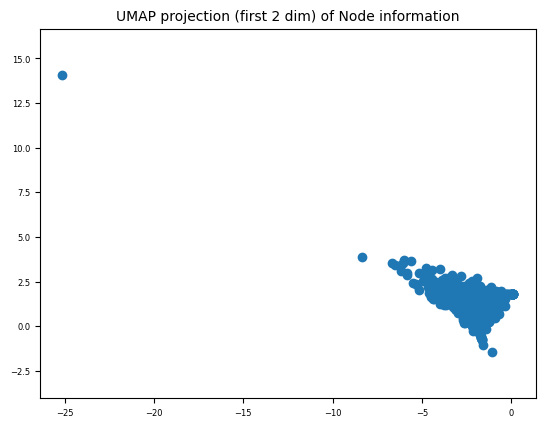

In [629]:
# plot umap embedding of nodes
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection (first 2 dim) of Node information')

same as above but using dataset from https://github.com/SeongJinAhn/VGNAE/blob/main/main.py to validate

In [19]:
from torch_geometric.utils import train_test_split_edges
from torch_geometric.datasets import Planetoid, Coauthor, Amazon
dataset = Planetoid("cora", "Cora", 'public')
data = dataset[0]
data = T.NormalizeFeatures()(data)

In [20]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 128
train_rate = 0.8
val_ratio = 0.2 / 3
test_ratio = 0.2 / 3 * 2
data = train_test_split_edges(data.to(dev), val_ratio=val_ratio, test_ratio=test_ratio)

C:\Users\lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [21]:
model = VGAE(Encoder(data.x.size()[1], channels, data.train_pos_edge_index)).to(dev)

In [15]:
data.train_mask = data.val_mask = data.test_mask = data.y = None
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [16]:
def train():
    model.train()
    optimizer.zero_grad()
    z  = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss

def test(pos_edge_index, neg_edge_index, plot_his=0):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [17]:
for epoch in range(1,100):
    loss = train()
    loss = float(loss)
    
    with torch.no_grad():
        test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
        auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
        print('Epoch: {:03d}, LOSS: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))

Epoch: 001, LOSS: 10.5961, AUC: 0.6936, AP: 0.7234
Epoch: 002, LOSS: 10.3247, AUC: 0.6953, AP: 0.7248
Epoch: 003, LOSS: 10.2399, AUC: 0.6970, AP: 0.7261
Epoch: 004, LOSS: 9.8528, AUC: 0.6987, AP: 0.7274
Epoch: 005, LOSS: 9.8399, AUC: 0.7007, AP: 0.7289
Epoch: 006, LOSS: 9.4896, AUC: 0.7026, AP: 0.7303
Epoch: 007, LOSS: 9.3072, AUC: 0.7048, AP: 0.7319
Epoch: 008, LOSS: 9.2995, AUC: 0.7072, AP: 0.7337
Epoch: 009, LOSS: 8.8477, AUC: 0.7100, AP: 0.7358
Epoch: 010, LOSS: 9.0528, AUC: 0.7135, AP: 0.7383
Epoch: 011, LOSS: 8.7333, AUC: 0.7177, AP: 0.7414
Epoch: 012, LOSS: 8.5690, AUC: 0.7231, AP: 0.7454
Epoch: 013, LOSS: 8.3032, AUC: 0.7302, AP: 0.7509
Epoch: 014, LOSS: 8.1966, AUC: 0.7396, AP: 0.7583
Epoch: 015, LOSS: 8.0069, AUC: 0.7523, AP: 0.7680
Epoch: 016, LOSS: 7.8474, AUC: 0.7706, AP: 0.7826
Epoch: 017, LOSS: 7.6897, AUC: 0.7985, AP: 0.8053
Epoch: 018, LOSS: 7.4065, AUC: 0.8373, AP: 0.8390
Epoch: 019, LOSS: 7.1321, AUC: 0.8854, AP: 0.8849
Epoch: 020, LOSS: 6.6308, AUC: 0.9218, AP: 0.92